# Spiral model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap

c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

Training SpiralNet
Computing UMAP


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


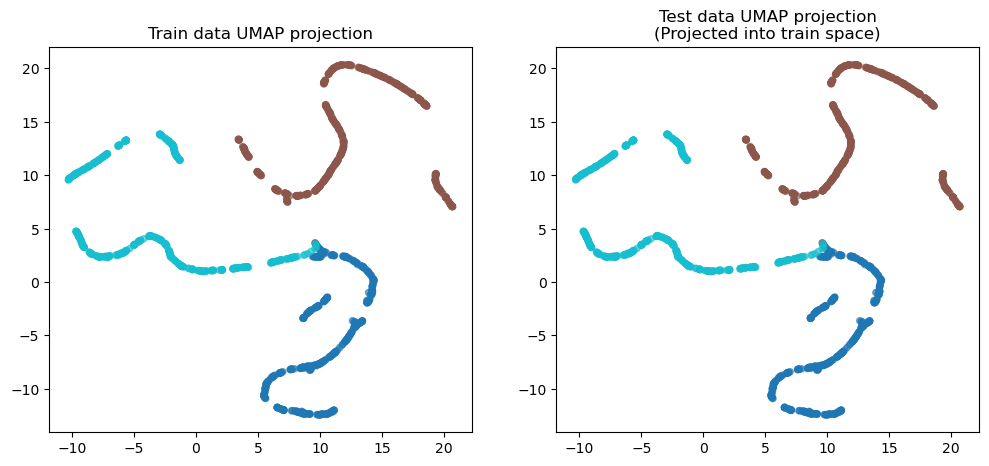

In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numLayers = 4
learningRate = 0.01

# ========================================
# Data and model (same as experiment 1)
# ========================================

def toySpiral3(N=200, K=3):
    """
    Generates a K-class (3 by default) spiral dataset.
    (We impose 2D for visualization purposes)
    
    :param N: Number of points per class
    :param K: Number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, 2))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N)
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)

class SpiralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(2, 2), nn.Tanh()) for _ in range(numLayers)])
        self.output = nn.Linear(2, 3)
    def forward(self, x):
        for layer in self.layers: 
            x = layer(x)
        return self.output(x), x

# ========================================
# Fast training
# ========================================

print("Training SpiralNet")
xTrain, yTrain = toySpiral3(N=500)
model = SpiralNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learningRate)
criterion = nn.CrossEntropyLoss()

for epoch in range(2000):
    logits, _ = model(xTrain)
    loss = criterion(logits, yTrain)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

# ========================================
# UMAP comparision (train vs test)
# ========================================

print("Computing UMAP")

# Generate test set
xTest, yTest = toySpiral3(N=500) 

# Feature extraction
model.eval()
with torch.no_grad():
    _, featsTrain = model(xTrain)
    _, featsTest  = model(xTest)

# UMAP fit on train set
reducer = umap.UMAP(random_state=42)
embeddingTrain = reducer.fit_transform(featsTrain.cpu().numpy())

# UMAP transform on test set
embeddingTest = reducer.transform(featsTest.cpu().numpy())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(embeddingTrain[:, 0], embeddingTrain[:, 1], c=yTrain.cpu(), cmap='tab10', s=20, alpha=0.6)
axes[0].set_title("Train data UMAP projection")
axes[1].scatter(embeddingTest[:, 0], embeddingTest[:, 1], c=yTest.cpu(), cmap='tab10', s=20, alpha=0.6)
axes[1].set_title("Test data UMAP projection\n(Projected into train space)")

plt.show()

_______________________
_______________________
# ResNet18

In [4]:
import time

In [5]:
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

Preparing ResNet18 model

UMAP test with 500 train samples


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP calculation time: 1.08s

UMAP test with 5000 train samples


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP calculation time: 18.82s


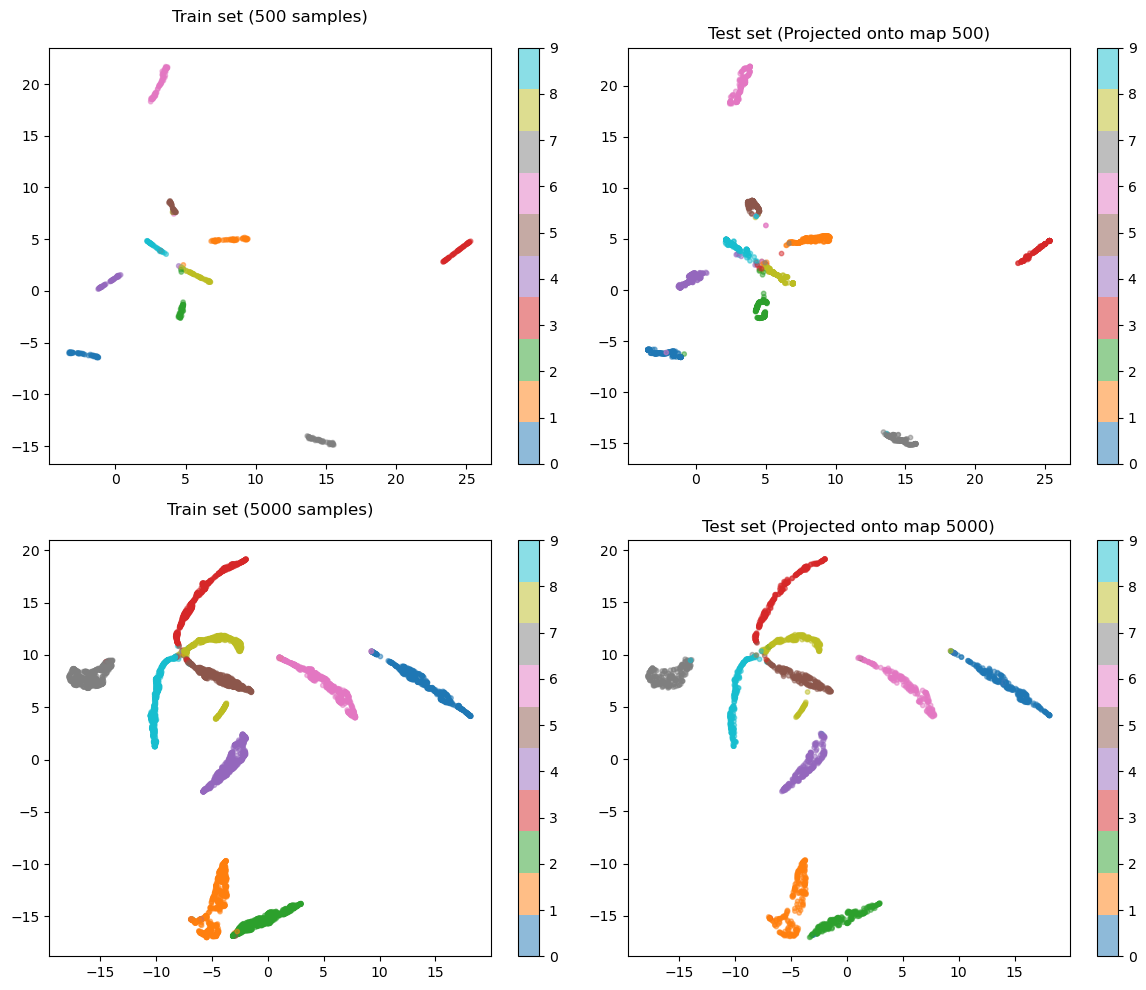

In [ ]:
# ==========================================
# Data loading and model preparation
# ==========================================

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainFull = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testFull = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Fast training (transfer learning) to get a performant model
print("Preparing ResNet18 model")
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 10)
model = model.to(DEVICE)

# Train just 1 epoch to get decent clusters
loader = torch.utils.data.DataLoader(trainFull, batch_size=128, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for x, y in loader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    optimizer.zero_grad()
    logits = model(x)
    nn.CrossEntropyLoss()(logits, y).backward()
    optimizer.step()

# ==========================================
# Feature extraction function
# ==========================================

def getFeatures(dataset, numSamples):
    """ 
    Extracts numSamples features from the dataset.

    :param dataset: Dataset to extract from
    :param numSamples: Number of samples to extract
    :return: features and labels arrays
    """
    indices = np.random.choice(len(dataset), numSamples, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    loader = torch.utils.data.DataLoader(subset, batch_size=100)
    
    allFeats = []
    allLabels = []
    
    # Simple hook to grab features (before flatten)
    body = nn.Sequential(*list(model.children())[:-1])
    
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            feats = body(x).flatten(1)
            allFeats.append(feats.cpu().numpy())
            allLabels.append(y.numpy())
            
    return np.concatenate(allFeats), np.concatenate(allLabels)

# ==========================================
# UMAP robustness test
# ==========================================

sample_sizes = [500, 5000]

plt.figure(figsize=(12, 10))

for i, n_train in enumerate(sample_sizes):
    print(f"\nUMAP test with {n_train} train samples")
    
    # Data extraction
    xTrainUMAP, yTrainUMAP = getFeatures(trainFull, n_train)
    xTestUMAP, yTestUMAP = getFeatures(testFull, 2000)
    
    # UMAP training
    start = time.time()
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddingTrain = reducer.fit_transform(xTrainUMAP) # fit on train data
    duration = time.time() - start
    print(f"UMAP calculation time: {duration:.2f}s")
    
    # Test projection
    embeddingTest = reducer.transform(xTestUMAP)       # transform on test data
    
    # Display
    plt.subplot(2, 2, i*2 + 1)
    plt.scatter(embeddingTrain[:, 0], embeddingTrain[:, 1], c=yTrainUMAP, cmap='tab10', s=10, alpha=0.5)
    plt.title(f"Train set ({n_train} samples)\n")
    plt.colorbar()
    
    plt.subplot(2, 2, i*2 + 2)
    plt.scatter(embeddingTest[:, 0], embeddingTest[:, 1], c=yTestUMAP, cmap='tab10', s=10, alpha=0.5)
    plt.title(f"Test set (projected onto map {n_train})")
    plt.colorbar()

plt.tight_layout()
plt.show()